# **第四章: 高级脑电数据分析**

***

高级脑电数据分析的这一章分成了以下四个部分：

- **第一节: 批处理读取与存储数据**
- **第二节: 基于分类的脑电解码**  
- **第三节: 表征相似性分析**
- **第四节: 反向编码模型**

## 下载并导入需要用到的Python包

In [1]:
! pip install inverted_encoding

import numpy as np
import sys
import os
from six.moves import urllib
import gdown
import zipfile
import scipy.io as sio
from scipy.stats import ttest_ind
import h5py
from tqdm import tqdm
from neurora.decoding import tbyt_decoding_kfold, ct_decoding_kfold
from neurora.rsa_plot import plot_tbyt_decoding_acc, \
                             plot_ct_decoding_acc, \
                             plot_rdm, plot_tbytsim_withstats
from neurora.rdm_cal import eegRDM
from neurora.corr_cal_by_rdm import rdms_corr
from neurora.stuff import smooth_1d
from inverted_encoding import IEM, permutation, circ_diff
from decimal import Decimal
import matplotlib.pyplot as plt

# 第一节 - 批处理读取与存储数据

### **预处理过的Demo数据2：**  
（你将会在第二节、第三节和第四节中使用）
原数据集基于Bae&Luck2019年发表在Journal of Neuroscience上的文章《Dissociable Decoding of Spatial Attention and Working Memory from EEG Oscillations and Sustained Potentials》实验2的数据  
这是一个视觉工作记忆任务，被试要求记忆一个水滴形状的朝向，刺激呈现200ms  
经过1300毫秒的延迟后呈现一个随机朝向的水滴形状，被试需要转动鼠标使朝向尽可能和记忆朝向一致  
刺激可能有16种不同的朝向以及16种不同的位置  
这里仅提取前5个被试的数据，数据为做过预处理并分好段之后的ERP数据（预处理参数见论文原文）并带有每一个试次的朝向和位置标签

In [2]:
# 下载Demo数据2

data_dir = "data/"
if not os.path.exists(data_dir):
  os.makedirs(data_dir)

# 从Google Drive下载
url = "https://drive.google.com/file/d/1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj/view?usp=sharing"
filename = "demo_data2"
filepath = data_dir + filename + ".zip"

# 下载数据
gdown.download(url=url, output=filepath, quiet=False, fuzzy=True)
print("Download completes!")
# 解压数据
with zipfile.ZipFile(filepath, 'r') as zip:
    zip.extractall(data_dir)
print("Unzip completes!")

# 也可以通过百度网盘下载
# 链接:https://pan.baidu.com/s/1mZdU9rL8vGn8-kjlUkF6PA  密码:8qih
# 下载后解压，并移动到data文件夹下

Downloading...
From (original): https://drive.google.com/uc?id=1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj
From (redirected): https://drive.google.com/uc?id=1POBi0dckB00AKCIvpXHZFI1Oqd-jWRoj&confirm=t&uuid=430b6aca-81e1-44b5-a6f4-a2daf145dc2c
To: /Users/zitonglu/Downloads/Python-EEG-Handbook-master/data/demo_data2.zip
100%|████████████████████████████████████████| 301M/301M [00:57<00:00, 5.27MB/s]


Download completes!
Unzip completes!


在'data'文件夹下包含5个被试的脑电数据.mat文件，在'labels'文件夹下包含每个被试所有试次对应刺激项的朝向标签文件和位置标签文件
以被试编号'201'为例，'ori_201.txt'文件包含其每一个试次的记忆项的朝向信息，'pos_201.txt'文件包含其每一个试次的记忆项的位置信息
数据中，导联数为27，采样率为250Hz，从刺激呈现前1.5s到刺激呈现后1.5s，每个试次包含750个时间点

### 批处理读取Demo数据2并存成.h5文件

In [3]:
# 5个被试的编号
sub_ids = ['201', '202', '203', '204', '205']

# 对5个被试的数据进行遍历
for i, sub in enumerate(sub_ids):
    
    # 每个被试ERP数据、记忆项朝向标签和记忆项位置标签的文件地址
    subdata_path = 'data/demo_data2/data/ERP' + sub + '.mat'
    suborilabels_path = 'data/demo_data2/labels/ori_' + sub + '.txt'
    subposlabels_path = 'data/demo_data2/labels/pos_' + sub + '.txt'
    
    # 读取ERP数据
    subdata = sio.loadmat(subdata_path)['filtData']
    # 读取记忆项的朝向和位置的标签
    # 在.txt文件里，第一列为具体的朝向/位置值，第二列为16个朝向/位置对应的标签值（0-15的整数表示）
    suborilabels = np.loadtxt(suborilabels_path)[:, 1]
    subposlabels = np.loadtxt(subposlabels_path)[:, 1]
    
    # 打印被试编号、ERP数据矩阵的shape及两个标签矩阵的shape
    print('sub' + sub)
    print(subdata.shape)
    print(suborilabels.shape)
    print(subposlabels.shape)
    
    # 将每个被试的ERP数据及朝向和位置的标签以‘data’、'orilabels'和‘poslabels’
    # 作为Keys存在一个.h5文件里
    f = h5py.File('data/demo_data2/sub' + sub + '.h5', 'w')
    f.create_dataset('data', data=subdata)
    f.create_dataset('orilabels', data=suborilabels)
    f.create_dataset('poslabels', data=subposlabels)
    f.close()

sub201
(640, 27, 750)
(640,)
(640,)
sub202
(640, 27, 750)
(640,)
(640,)
sub203
(640, 27, 750)
(640,)
(640,)
sub204
(640, 27, 750)
(640,)
(640,)
sub205
(640, 27, 750)
(640,)
(640,)


# 第二节 - 基于分类的脑电解码

### Get EEG Data and Labels

In [4]:
subs = ["201", "202", "203", "204", "205"]

# 初始化三个变量data、label_ori和label_pos
# 分别用于后续存储脑电数据、朝向的标签和位置的标签
data = np.zeros([5, 640, 27, 500])
label_ori = np.zeros([5, 640])
label_pos = np.zeros([5, 640])

for i, sub in enumerate(subs):

    # 读取单个被试的.h5文件
    subfile = h5py.File('data/demo_data2/sub' + sub + '.h5', 'r')
    
    # 获取EEG数据
    subdata = subfile['data']
    
    # subdata的shape为[640, 27, 750]
    # 640 - 试次数； 27 - 导联数； 750 - 时间点数（从-1.5s到1.5s）

    # 取-0.5s到1.5s的数据
    subdata = subdata[:, :, 250:]
    
    # 读取朝向和位置标签
    sublabel_ori = subfile['orilabels']
    sublabel_pos = subfile['poslabels']
    
    data[i] = subdata
    label_ori[i] = sublabel_ori
    label_pos[i] = sublabel_pos

### 逐时间点解码与结果可视化

#### 对朝向信息进行逐时间点解码

In [5]:
# 这里使用NeuroRA的decoding模块下的tbyt_decoding_kfold()函数进行逐时间点解码
# 传入数据（shape为[n_subs, n_trials, n_channels, n_times]）、对应每个试次的标签
# 以及一些其他参数：
# n=16 - 分类类别数为16（共16中朝向）
# navg=13 - 对13个试次进行一次平均
# time_win=5 - 时间窗为5（即5个时间点的数据进行一次平均）
# time_step=5 - 时间步长为5（即每间隔5个时间点进行一次解码）
# nfolds=3 & nrepeats=10 - 进行10次3折的交叉验证
# smooth=True - 对结果进行平滑处理
accs_ori = tbyt_decoding_kfold(data, label_ori, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### 对朝向信息解码结果的可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
200ms to 520ms
679ms to 800ms


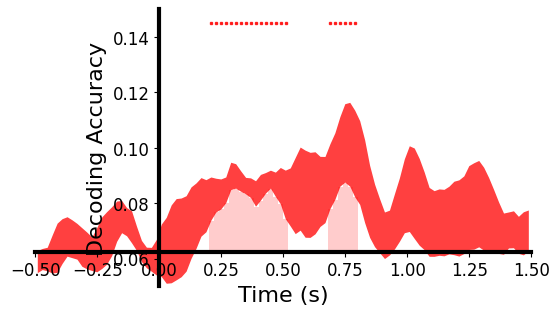

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [6]:
# 这里使用NeuroRA的decoding模块下的plot_tbyt_decoding_acc()函数进行统计分析与可视化
# 其要求输入解码的结果（shape为[n_subs, n_results_times]）和一些其他参数：
# start_time=-0.5 - 解码结果的开始时间为-0.5s
# end_time=1.5 - 解码结果的结束时间为1.5s、
# time_interval=0.02 - 两解码时间间隔为0.02s
#（由于时间窗为5，数据原采样率为250Hz，5*(1/250)=0.02s）、
# chance=0.0625 - 随机水平的分类准确率为0.0625（16个朝向，即1/16）
# p=0.05 - p值的阈值、
# cbpt=True - 进行cluster-based permutation test、
# stats_time=[0, 1.5] - 统计0-1.5s的解码结果、
# xlim=[-0.5, 1.5] - x轴显示范围从-0.5到1.5
# ylim=[0.05, 0.15] - y轴显示范围从0到1.5
plot_tbyt_decoding_acc(accs_ori, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

#### 对位置信息进行逐时间点解码

In [7]:
accs_pos = tbyt_decoding_kfold(data, label_pos, n=16, navg=13, time_win=5, time_step=5, 
                               nfolds=3, nrepeats=10, smooth=True)

Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### 对位置信息解码结果的可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
79ms to 459ms
600ms to 740ms
919ms to 1200ms
1220ms to 1320ms


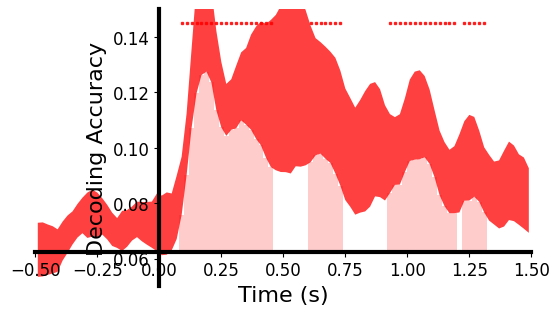

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [8]:
plot_tbyt_decoding_acc(accs_pos, start_time=-0.5, end_time=1.5, time_interval=0.02, 
                       chance=0.0625, p=0.05, cbpt=True, stats_time=[0, 1.5], 
                       xlim=[-0.5, 1.5], ylim=[0.05, 0.15])

### 跨时域脑电解码

#### 对朝向和位置信息进行跨时域脑电解码

朝向解码

In [9]:
# 这里使用NeuroRA的decoding模块下的ct_decoding_kfold()函数进行跨时域解码
accs_crosstime_ori = ct_decoding_kfold(data, label_ori, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!



位置解码

In [10]:
accs_crosstime_pos = ct_decoding_kfold(data, label_pos, n=16, navg=13,
                                       time_win=5, time_step=5, 
                                       nfolds=3, nrepeats=10, smooth=True)


Decoding
Calculating: [====================================================================================================] 100.00%
Decoding finished!



#### 对朝向和位置跨时域解码结果的可视化

朝向解码


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



/Users/zitonglu/anaconda3/lib/python3.11/site-packages/neurora/rsa_plot.py:1050: UserWarning: No contour levels were found within the data range.
  plt.contour(X, Y, np.transpose(newps, (1, 0)), [0, 1], colors="silver", alpha=0.9, linewidths=3,


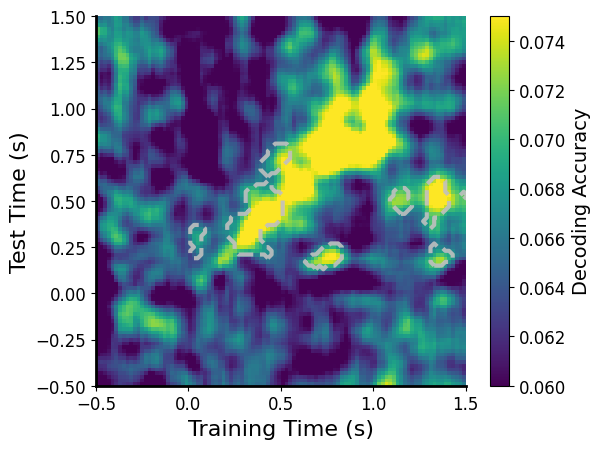

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
# 这里使用NeuroRA的decoding模块下的plot_ct_decoding_acc()函数进行统计分析与可视化
plot_ct_decoding_acc(accs_crosstime_ori, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

位置解码


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!



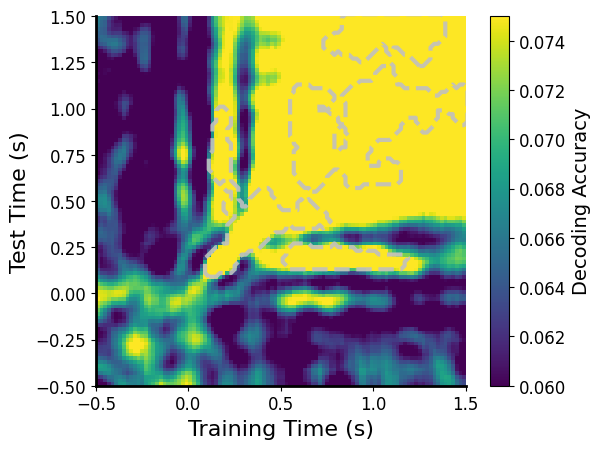

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [12]:
plot_ct_decoding_acc(accs_crosstime_pos, start_timex=-0.5, end_timex=1.5, 
                     start_timey=-0.5, end_timey=1.5,
                     time_intervalx=0.02, time_intervaly=0.02, 
                     chance=0.0625, p=0.05, cbpt=True,
                     stats_timex=[0, 1.5], stats_timey=[0, 1.5], 
                     xlim=[-0.5, 1.5], ylim=[-0.5, 1.5], clim=[0.06, 0.075])

# 第三节 - 表征相似性分析

### 计算脑电表征不相似性矩阵（Representational Dissimilarity Matrices，RDMs）

根据16个朝向和16个位置，分别计算逐时间点的16×16的表征朝向信息的脑电RDM和表征位置信息的脑电RDM

In [13]:
n_subs = 5
n_trials = 640
# 首先对数据进行重新划分
# 分别获取16个朝向条件下的脑电数据和16个位置条件下的脑电数据
# 初始化两个变量data_ori和data_pos分别用于存储朝向和位置的数据
data_ori = np.zeros([16, n_subs, 40, 27, 500])
data_pos = np.zeros([16, n_subs, 40, 27, 500])
for sub in range(n_subs):
    index_ori = np.zeros([16], dtype=int)
    index_pos = np.zeros([16], dtype=int)
    for i in range(n_trials):
        ori = int(label_ori[sub, i])
        pos = int(label_pos[sub, i])
        data_ori[ori, sub, index_ori[ori]] = data[sub, i]
        index_ori[ori] = index_ori[ori] + 1
        data_pos[pos, sub, index_pos[pos]] = data[sub, i]
        index_pos[pos] = index_pos[pos] + 1
        
# 使用NeuroRA的rdm_cal模块下的eegRDM()函数计算脑电RDMs
# 朝向RDMs
RDMs_ori = eegRDM(data_ori, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# 位置RDMs
RDMs_pos = eegRDM(data_pos, sub_opt=1, chl_opt=0, time_opt=1, time_win=5, time_step=5)
# 返回的RDMs_ori和RDMs_pos的shape均为[n_subs即5, n_results_time即100, 16, 16]


Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!

Computing RDMs
Calculating: [====================================================================================================] 100.00%
RDMs computing finished!


### 构建基于假设的表征不相似矩阵

这里基于两角度越接近相似性约高、两角度越不接近相似性越低的假设  
构建了一个编码模型RDM，此例中，对朝向和位置信息均适用

1


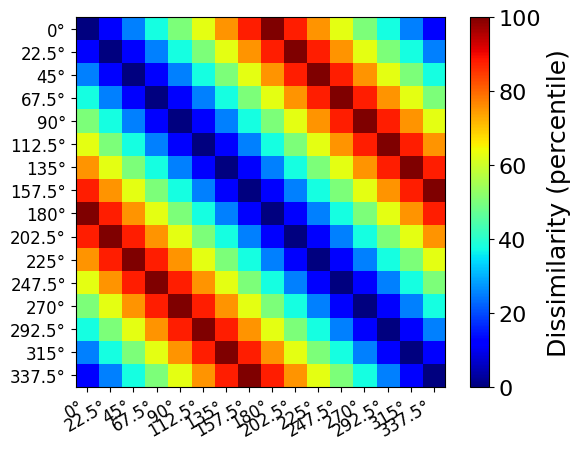

0

In [14]:
model_RDM = np.zeros([16, 16])
for i in range(16):
    for j in range(16):
        diff = np.abs(i - j)
        if diff <= 8:
            model_RDM[i, j] = diff / 8
        else:
            model_RDM[i, j] = (16 - diff) / 8

# 使用NeuroRA的rsa_plot模块下的plot_rdm()函数可视化RDM
conditions = ["0°", "22.5°", "45°", "67.5°", "90°", "112.5°", "135°", "157.5°", "180°",
              "202.5°", "225°", "247.5°", "270°", "292.5°", "315°", "337.5°"]
plot_rdm(model_RDM, percentile=True, conditions=conditions)

### 相似性分析（Representational Similarity Analysis, RSA）

使用基于假设的模型RDM分别与朝向表征的脑电RDMs和位置表征的脑电RDMs计算相似性  
来时序上追踪大脑何时符合对朝向的编码、何时符合对位置的编码

In [15]:
# 使用NeuroRA的corr_cal_by_rdm模块下的rdms_corr()函数
# 计算基于假设的RDM和朝向的EEG RDMs的相似性
similarities_ori = rdms_corr(model_RDM, RDMs_ori)
# 计算基于假设的RDM和位置的EEG RDMs的相似性
similarities_pos = rdms_corr(model_RDM, RDMs_pos)


Computing similarities

Computing finished!

Computing similarities

Computing finished!


基于RSA的大脑对朝向信息编码的结果可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
219ms to 360ms
380ms to 620ms
640ms to 880ms


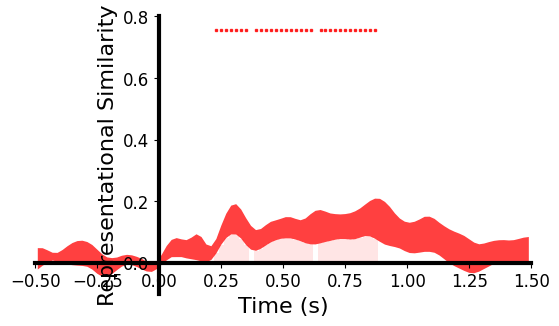

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
# 使用NeuroRA的rsa_plot模块下的plot_tbytsim_withstats()函数
# 用法与plot_tbyt_decoding_acc()函数类似
plot_tbytsim_withstats(similarities_ori, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

基于RSA的大脑对位置信息编码的结果可视化


Permutation test
Calculating: [====================================================================================================] 100.00%
Cluster-based permutation test finished!


Significant time-windows:
40ms to 1020ms


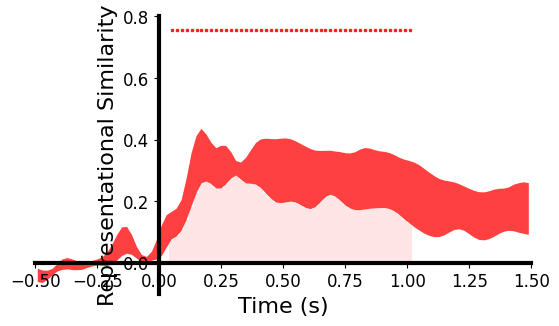

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [17]:
plot_tbytsim_withstats(similarities_pos, start_time=-0.5, end_time=1.5, 
                       time_interval=0.02, smooth=True, p=0.05, cbpt=True, 
                       stats_time=[0, 1.5], xlim=[-0.5, 1.5], ylim=[-0.1, 0.8])

# 第四节 - 反向编码模型

这部分，我们参考预印本“*Scotti, P. S., Chen, J., & Golomb, J. D. (2021). An enhanced inverted encoding model for neural reconstructions. bioRxiv*”使用强化版反向编码模型（enhanced inverted encoding model, eIEM）

#### 使用eIEM解码朝向信息

In [18]:
n_subs = 5
n_ts = 100

# 初始化mae_ori来存储IEM解码的MAE结果
mae_ori = np.zeros([n_subs, n_ts])

# 使用Inverted_Encoding的IEM函数计算逐被试、逐时间点的MAE
for t in tqdm(range(n_ts)):
    for sub in range(n_subs):
        
        # 降采样数据 - 即对每5个时间点平均
        data_t_sub = np.average(data[sub, :, :, t*5:t*5+5], axis=2)
        
        # 获取IEM预测结果
        predictions, _, _, _ = IEM(data_t_sub, label_ori[sub].astype(int),
                                   stim_max=16, nfolds=5, is_circular=True)
        
        # 计算MAE
        mae_ori[sub, t] = np.mean(np.abs(circ_diff(predictions, label_ori[sub].astype(int), 16)))

# 使用Inverted_Encoding的permutation()函数获取MAE的Null分布
null_mae_ori = permutation(label_ori[sub].astype(int), stim_max=16,num_perm=5000, is_circular=True)

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


#### 定义绘制eIEM结果的函数 - plot_iem_results()

为了可视化，我们计算$\Delta$MAE（null MAE的均值减MAE）作为最终的IEM结果

In [19]:
def plot_iem_results(mae_ori, null_mae, start_time=0, end_time=1, time_interval=0.01,
                     stats_time=[0, 1], xlim=[0, 1], ylim=[-0.1, 0.8]):

    """
    参数：
        mae：shape为[n_subs, n_times]的矩阵，对应每个被试的MAE结果
        null_mae：shape为[num_perm]的矩阵，对应Null分布
        start_time：起始时间，默认为0
        end_time：结束时间，默认为1
        time_interval：两时间点之间的间隔，默认为0.01
        xlim：X轴范围，默认[0, 1]
        ylim：Y轴范围，默认[0.4, 0.8]
    """

    if len(np.shape(mae_ori)) != 2:

        return "Invalid input!"

    n = len(np.shape(mae_ori))

    yminlim = ylim[0]
    ymaxlim = ylim[1]

    nsubs, nts = np.shape(mae_ori)
    tstep = float(Decimal((end_time - start_time) / nts).quantize(Decimal(str(time_interval))))

    if tstep != time_interval:
        return "Invalid input!"

    delta1 = (stats_time[0] - start_time) / tstep - int((stats_time[0] - start_time) / tstep)
    delta2 = (stats_time[1] - start_time) / tstep - int((stats_time[1] - start_time) / tstep)

    mae_ori = smooth_1d(mae_ori)

    avg = np.average(np.average(null_mae)-mae_ori, axis=0)
    err = np.zeros([nts])

    for t in range(nts):
        err[t] = np.std(mae_ori[:, t], ddof=1)/np.sqrt(nsubs)

    ps = np.zeros([nts])
    for t in range(nts):
        ps[t] = ttest_ind(mae_ori[:, t], null_mae, alternative='less')[1]
        if ps[t] < 0.05:
            ps[t] = 1
        else:
            ps[t] = 0

    print('\nSignificant time-windows:')
    for t in range(nts):
        if t == 0 and ps[t] == 1:
            print(str(int(start_time * 1000)) + 'ms to ', end='')
        if t > 0 and ps[t] == 1 and ps[t - 1] == 0:
            print(str(int((start_time + t * tstep) * 1000)) + 'ms to ', end='')
        if t < nts - 1 and ps[t] == 1 and ps[t + 1] == 0:
            print(str(int((start_time + (t + 1) * tstep) * 1000)) + 'ms')
        if t == nts - 1 and ps[t] == 1:
            print(str(int(end_time * 1000)) + 'ms')

    for t in range(nts):
        if ps[t] == 1:
            plt.plot(t*tstep+start_time+0.5*tstep, (ymaxlim-yminlim)*0.95+yminlim, 's',
                     color='r', alpha=0.8, markersize=2)
            xi = [t*tstep+start_time, t*tstep+tstep+start_time]
            ymin = [0]
            ymax = [avg[t]-err[t]]
            plt.fill_between(xi, ymax, ymin, facecolor='r', alpha=0.1)

    fig = plt.gcf()
    fig.set_size_inches(6.4, 3.6)

    ax = plt.gca()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(3)
    ax.spines["left"].set_position(("data", 0))
    ax.spines["bottom"].set_linewidth(3)
    ax.spines['bottom'].set_position(('data', 0))
    x = np.arange(start_time+0.5*tstep, end_time+0.5*tstep, tstep)
    plt.plot(x, avg, color='r', alpha=0.95)
    plt.fill_between(x, avg + err, avg - err, facecolor='r', alpha=0.75)
    plt.ylim(yminlim, ymaxlim)
    plt.xlim(xlim[0], xlim[1])
    plt.tick_params(labelsize=12)
    plt.xlabel('Time (s)', fontsize=16)
    plt.ylabel(r'$\Delta$MAE', fontsize=16)
    
    plt.show()

    return ps

绘制朝向信息的IEM结果


Significant time-windows:
219ms to 1440ms


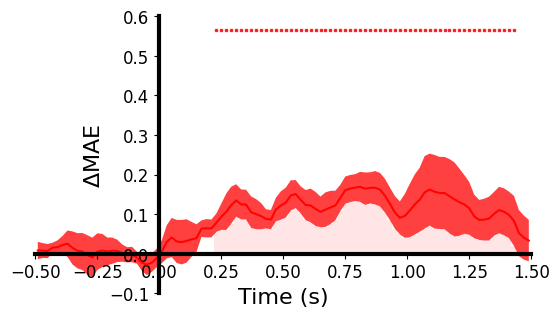

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [20]:
plot_iem_results(mae_ori, null_mae_ori, start_time=-0.5, end_time=1.5, time_interval=0.02,
                 xlim=[-0.5, 1.5], ylim=[-0.1, 0.6])

#### 使用eIEM解码位置信息

In [21]:
# 初始化mae_pos来存储IEM解码的MAE结果
mae_pos = np.zeros([n_subs, n_ts])

# 使用Inverted_Encoding的IEM函数计算逐被试、逐时间点的MAE
for t in tqdm(range(n_ts)):
    for sub in range(n_subs):
        
        # 降采样数据 - 即对每5个时间点平均
        data_t_sub = np.average(data[sub, :, :, t*5:t*5+5], axis=2)
        
        # 获取IEM预测结果
        predictions, _, _, _ = IEM(data_t_sub, label_pos[sub].astype(int), stim_max=16, nfolds=5, is_circular=True)
        
        # 计算MAE
        mae_pos[sub, t] = np.mean(np.abs(circ_diff(predictions, label_pos[sub].astype(int), 16)))

# 使用Inverted_Encoding的permutation()函数获取MAE的Null分布
null_mae_pos = permutation(label_pos[sub].astype(int), stim_max=16, num_perm=5000, is_circular=True)

100%|█████████████████████████████████████████| 100/100 [01:28<00:00,  1.13it/s]


绘制位置信息的IEM结果


Significant time-windows:
0ms to 1500ms


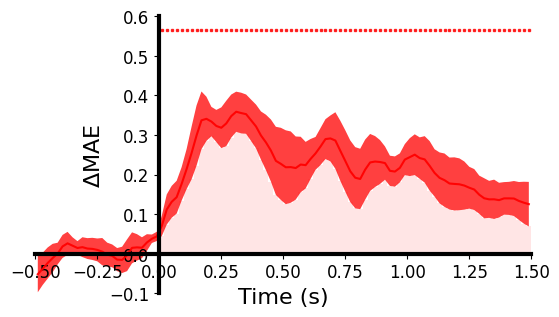

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [22]:
plot_iem_results(mae_pos, null_mae_pos, start_time=-0.5, end_time=1.5, time_interval=0.02,
                 xlim=[-0.5, 1.5], ylim=[-0.1, 0.6])